In [2]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tueplots import figsizes

import sys
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [3]:
from analysis import sweep2df, create_violinplot, format_violin, violin_by_prior

In [4]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

# Data loading

In [5]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "k2u5yzbe"


In [6]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"mlp_sweep_{SWEEP_ID}.csv"

In [7]:
runs_df = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading mlp_sweep_k2u5yzbe.csv...


In [8]:
runs_df = runs_df[runs_df.gamma_square <= 1e5]

## Data inspection

In [12]:
runs_df[[ "cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

cima4min_neg_elbo                                          \
                         count      mean       std       min       25%   
gamma_square                                                             
10.0                      20.0  0.000323  0.000192  0.000081  0.000206   
100.0                     20.0  0.000080  0.000047  0.000044  0.000049   
1000.0                    20.0  0.000085  0.000036  0.000038  0.000061   
10000.0                   20.0  0.000194  0.000122  0.000070  0.000122   
100000.0                  20.0  0.002921  0.004313  0.000150  0.000670   
1000000.0                 20.0  0.011433  0.014424  0.000535  0.003817   

                                            
                   50%       75%       max  
gamma_square                                
10.0          0.000280  0.000422  0.000786  
100.0         0.000068  0.000087  0.000239  
1000.0        0.000069  0.000124  0.000152  
10000.0       0.000150  0.000206  0.000508  
100000.0      0.001527  0.002333  0.015286  
1000000.0     0.007682  0.013934  0.067504

In [13]:
runs_df[[ "mcc4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

mcc4min_neg_elbo                                          \
                        count      mean       std       min       25%   
gamma_square                                                            
10.0                     20.0  0.772567  0.069567  0.657052  0.718902   
100.0                    20.0  0.817722  0.070872  0.690639  0.764773   
1000.0                   20.0  0.820650  0.074847  0.673085  0.781316   
10000.0                  20.0  0.819645  0.075730  0.677624  0.774213   
100000.0                 20.0  0.819170  0.073330  0.687830  0.777809   
1000000.0                20.0  0.818180  0.073318  0.700416  0.778697   

                                            
                   50%       75%       max  
gamma_square                                
10.0          0.787214  0.803759  0.913309  
100.0         0.829019  0.861029  0.967725  
1000.0        0.835685  0.866475  0.973323  
10000.0       0.845035  0.867481  0.968253  
100000.0      0.834189  0.870567  0.966177  
1000000.0     0.830764  0.869964  0.965708

In [14]:
runs_df[[ "min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

min_neg_elbo                                                    \
                    count      mean       std       min       25%       50%   
gamma_square                                                                  
10.0                 20.0  4.263436  0.002470  4.258281  4.261927  4.263021   
100.0                20.0  4.276257  0.005615  4.267282  4.271860  4.276455   
1000.0               20.0  4.329178  0.021063  4.294472  4.311069  4.327895   
10000.0              20.0  4.504620  0.079485  4.392209  4.443849  4.498628   
100000.0             20.0  5.145434  0.364360  4.777776  4.901717  5.043657   
1000000.0            20.0  8.800124  2.260568  6.828425  7.397291  8.272244   

                                   
                   75%        max  
gamma_square                       
10.0          4.265005   4.268206  
100.0         4.278580   4.288528  
1000.0        4.343697   4.373414  
10000.0       4.560320   4.651727  
100000.0      5.209848   6.169360  
1000000.0     9.172992  16.827099

# Data Pre-processing

$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [10]:
df_rhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "rhs" in col]].stack().droplevel(1), columns=["rhs"])
df_lhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "sigma" in col]].stack().droplevel(1), columns=["lhs"])
df_rhs_lhs_gamma_sq = df_rhs.merge( df_lhs, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

In [11]:
df_mse_sources_mean_decoded_sources = pd.DataFrame(runs_df[[col for col in runs_df.columns if col == "mse_sources_mean_decoded_sources"]].stack().droplevel(1), columns=["mse_sources_mean_decoded_sources"])
df_mse_obs_decoded_mean_latents = pd.DataFrame(runs_df[[col for col in runs_df.columns if col == "mse_obs_decoded_mean_latents"]].stack().droplevel(1), columns=["mse_obs_decoded_mean_latents"])
df_mse_gamma_sq = df_mse_sources_mean_decoded_sources.merge( df_mse_obs_decoded_mean_latents, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

# Plot

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_50502/1097031330.py:32: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(im)


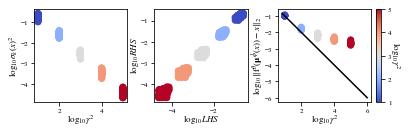

In [12]:
TICK_PADDING = 2
LABELPAD = 0

fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=2)['figure.figsize'])

ax = fig.add_subplot(131)
cmap = "coolwarm"
im = ax.scatter(np.log10(df_rhs_lhs_gamma_sq.gamma_square), np.log10(df_rhs_lhs_gamma_sq.lhs), c=np.log10(df_rhs_lhs_gamma_sq.gamma_square), cmap=cmap)
# ax.plot(np.linspace(.85, 6), -np.linspace(.85, 6), c="black", label='$y=x^{-2}$')
ax.set_ylabel("$\log_{10}\sigma_k(x)^2$", labelpad=LABELPAD)
ax.set_xlabel("$\log_{10}\gamma^2$", labelpad=LABELPAD)
# plt.legend()
ax.tick_params(axis='both', which='major', pad=TICK_PADDING)
ax = fig.add_subplot(132)
ax.scatter(np.log10(df_rhs_lhs_gamma_sq.lhs), np.log10(df_rhs_lhs_gamma_sq.rhs), c=np.log10(df_rhs_lhs_gamma_sq.gamma_square), cmap=cmap)
# ax.plot(np.linspace(-6, 0.), np.linspace(-6, 0.), c="black", label='$y=x$')
ax.set_ylabel("$\log_{10} RHS$", labelpad=LABELPAD)
ax.set_xlabel("$\log_{10} LHS$", labelpad=LABELPAD)
# plt.legend()
ax.tick_params(axis='both', which='major', pad=TICK_PADDING)


ax = fig.add_subplot(133)
ax.scatter(np.log10(df_mse_gamma_sq.gamma_square), np.log10(np.sqrt(df_mse_gamma_sq.mse_obs_decoded_mean_latents)), c=np.log10(df_mse_gamma_sq.gamma_square), cmap=cmap)
ax.plot(np.linspace(.85, 6), -np.linspace(.85, 6), c="black", label='$y=x$')
ax.set_ylabel(r"$\log_{10}\Vert {\mathbf{\rm f}^\theta}(\mathbf{\mu}^{\hat{\phi}}(x)) - x \Vert_2$", labelpad=LABELPAD)

ax.set_xlabel("$\log_{10}\gamma^2$", labelpad=LABELPAD)
# plt.legend()
ax.tick_params(axis='both', which='major', pad=TICK_PADDING)

cbar = fig.colorbar(im)
# cbar.ax.set_yticklabels(['0','1','2','>3'])
cbar.set_label('$\log_{10}\gamma^2$', rotation=270)
cbar.ax.get_yaxis().labelpad = 10
plt.savefig("self_cons_mlp_gauss.svg")

# Sandbox

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/2860315922.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


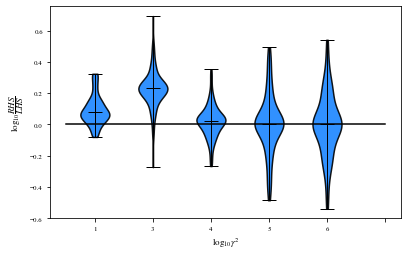

In [503]:
groups = [np.log10((g.rhs/g.lhs).abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
create_violinplot(groups, '$\log_{10}\gamma^2$', '$\log_{10}\dfrac{RHS}{LHS}$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="opt_sigma_gamma")
plt.plot(np.linspace(0.5, 6), 0*np.linspace(0.5, 6), c="black")

In [608]:
elbo_filter = runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").describe()['neg_elbo']['max']
groups = [g for _, g in runs_df[[ "neg_elbo", "mcc4min_neg_elbo", "cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square")]
gg_mcc = [g[g.neg_elbo <= threshold].mcc4min_neg_elbo  for g, threshold in zip(groups, elbo_filter)]
gg_cima = [g[g.neg_elbo <= threshold].cima4min_neg_elbo  for g, threshold in zip(groups, elbo_filter)]
gg_gamma = [g[g.neg_elbo <= threshold].gamma_square  for g, threshold in zip(groups, elbo_filter)]

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/2860315922.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


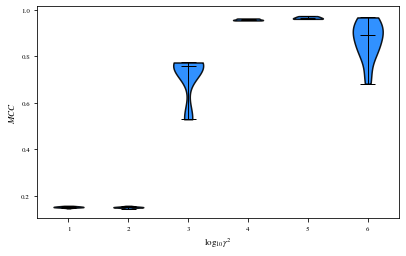

In [609]:
create_violinplot(gg_mcc, '$\log_{10}\gamma^2$', '$MCC$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="mcc_vs_gamma")

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/2860315922.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


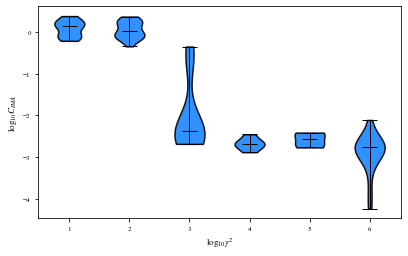

In [610]:
create_violinplot([np.log10(g) for g in gg_cima], '$\log_{10}\gamma^2$', '$\log_{10}C_{IMA}$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="cima_vs_gamma")

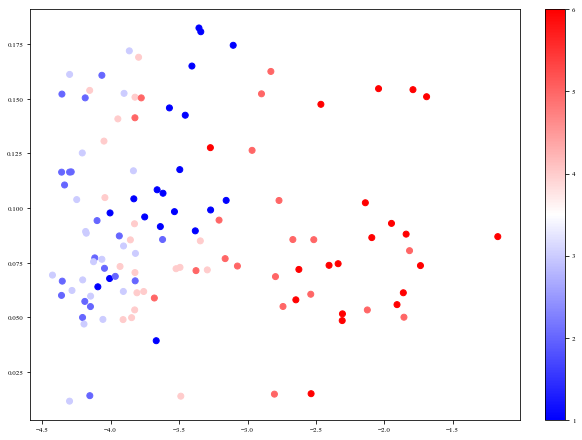

In [529]:
plt.figure(figsize=(8,6))
plt.scatter([np.log10(item) for sublist in gg_cima for item in sublist], [-np.log10(item) for sublist in gg_mcc for item in sublist], c=[np.log10(item) for sublist in gg_gamma for item in sublist], cmap=cmap)
plt.colorbar()

In [494]:
larger_gamma_df = runs_df[runs_df['gamma_square']>100]

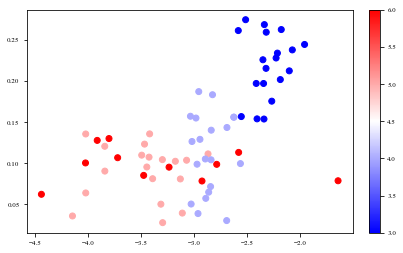

In [495]:
plt.scatter(np.log10(larger_gamma_df['cima4min_neg_elbo']), -np.log10(larger_gamma_df['mcc4min_neg_elbo']), c=np.log10(larger_gamma_df['gamma_square']), cmap=(
            '%s' % cmap))
plt.colorbar()

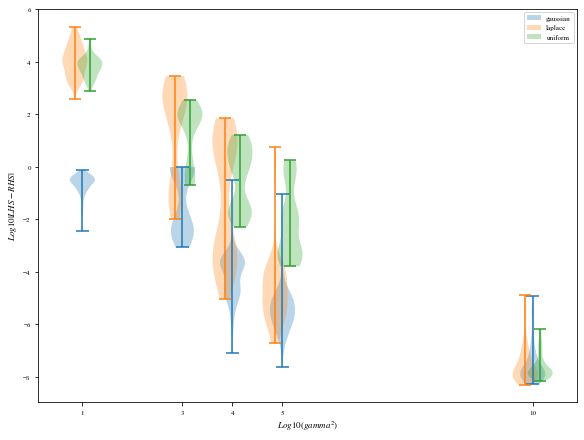

In [49]:
violin_by_prior(lhs_rhs_vs_gamma_gauss, lhs_rhs_vs_gamma_laplace, lhs_rhs_vs_gamma_uniform,  np.unique(np.log10(gamma_uniform_ext)), '$Log10(gamma^2)$', '$Log10|LHS-RHS|$',  0.15, 'opt_sigma_vs_gamma', log=True)